<a href="https://colab.research.google.com/github/flororsi/Natural_language_processing/blob/main/Scrapping_analyzing_playstore_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup



In [1]:
!pip install -qq google-play-scraper

     |████████████████████████████████| 51kB 1.5MB/s 


In [2]:
!pip install -qq -U watermark

In [3]:
%reload_ext watermark
%watermark -v -p pandas,matplotlib,seaborn,google_play_scraper

CPython 3.6.9
IPython 5.5.0

pandas 1.1.2
matplotlib 3.2.2
seaborn 0.11.0
google_play_scraper 0.1.1


In [4]:
import json
import pandas as pd
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from pygments import highlight
from pygments.lexers import JsonLexer
from pygments.formatters import TerminalFormatter

from google_play_scraper import Sort, reviews, app

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

# Scrapping the information, creating CSV

In [5]:
app_packages = [
  'com.mcdo.mcdonalds',
  'com.candoit.mostaza',
  'com.grido.app',
  'com.starbucks.ar',
  'ar.burgerking',
]

In [6]:
app_infos = []

for ap in tqdm(app_packages):
  info = app(ap, lang='es', country='ar')
  del info['comments']
  app_infos.append(info)

100%|██████████| 5/5 [00:00<00:00,  5.80it/s]


In [7]:
def print_json(json_object):
  json_str = json.dumps(
    json_object, 
    indent=2, 
    sort_keys=True, 
    default=str
  )
  print(highlight(json_str, JsonLexer(), TerminalFormatter()))

In [8]:
print_json(app_infos[4])

{
  "adSupported": null,
  "androidVersion": "4.4",
  "androidVersionText": "4.4 y versiones posteriores",
  "appId": "ar.burgerking",
  "containsAds": false,
  "contentRating": "Para todos",
  "contentRatingDescription": null,
  "currency": "USD",
  "description": "Aplicaci\u00f3n oficial de Burger King\u00ae Argentina para acceder a descuentos y beneficios exclusivos.\r\nDescubr\u00ed la mejor forma de comer tus hamburguesas a la parrilla preferidas a precios \u00fanicos. Eleg\u00ed tu opci\u00f3n ideal, acercate a cualquiera de nuestros locales y prob\u00e1 nuestra famosa Whopper\u00ae o la cl\u00e1sica Stacker\u00ae y acompa\u00f1alas con crujientes papas fritas o con los deliciosos aros de cebolla especialmente empanados.\r\nDisfrut\u00e1 tu comida favorita de Burger King\u00ae sin l\u00edmites.",
  "descriptionHTML": "Aplicaci\u00f3n oficial de Burger King\u00ae Argentina para acceder a descuentos y beneficios exclusivos.<br>Descubr\u00ed la mejor forma de comer tus hamburguesas 

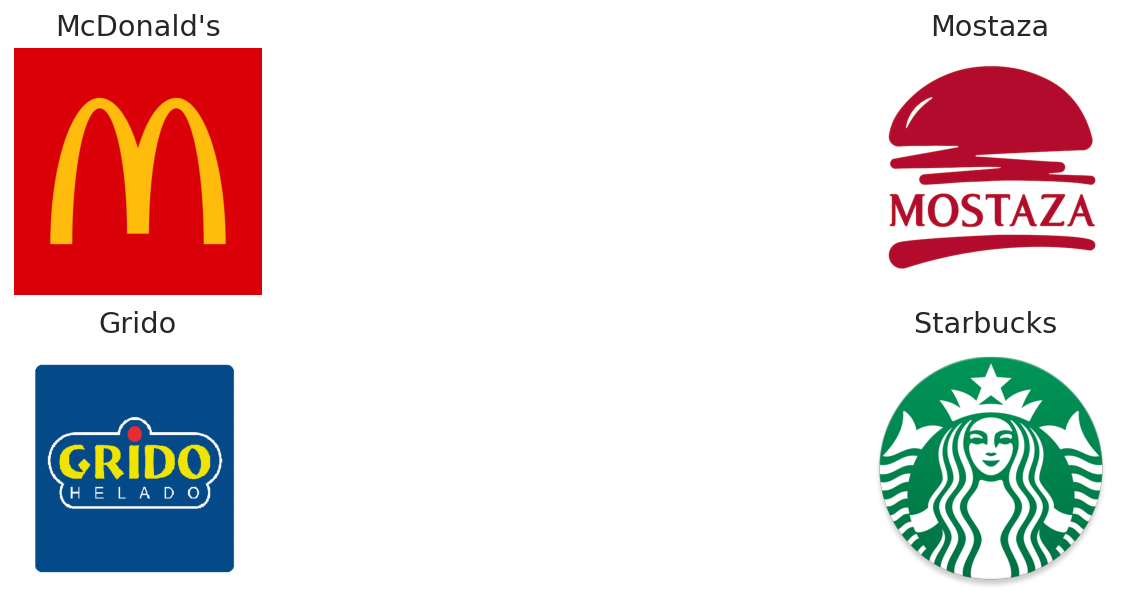

In [9]:
def format_title(title):
  sep_index = title.find(':') if title.find(':') != -1 else title.find('-')
  if sep_index != -1:
    title = title[:sep_index]
  return title[:10]

fig, axs = plt.subplots(2, len(app_infos) // 2, figsize=(14, 5))

for i, ax in enumerate(axs.flat):
  ai = app_infos[i]
  img = plt.imread(ai['icon'])
  ax.imshow(img)
  ax.set_title(format_title(ai['title']))
  ax.axis('off')

In [10]:
app_infos_df = pd.DataFrame(app_infos)
app_infos_df.to_csv('apps.csv', index=None, header=True)

# Scrapping the reviews

In [11]:
app_reviews = []

for ap in tqdm(app_packages):
  for score in list(range(1, 6)):
    for sort_order in [Sort.MOST_RELEVANT, Sort.NEWEST]:
      rvs, _ = reviews(
        ap,
        lang='es',
        country='ar',
        sort=sort_order,
        count= 200 if score == 3 else 100,
        filter_score_with=score
      )
      for r in rvs:
        r['sortOrder'] = 'most_relevant' if sort_order == Sort.MOST_RELEVANT else 'newest'
        r['appId'] = ap
      app_reviews.extend(rvs)

100%|██████████| 5/5 [00:10<00:00,  2.03s/it]


In [12]:
print_json(app_reviews[1])

{
  "appId": "com.mcdo.mcdonalds",
  "at": "2020-10-22 14:03:37",
  "content": "Por favor arreglar la app! A cada rato pide login y inicie seci\u00f3n con todas las opciones y no me deja sacar ning\u00fan cup\u00f3n-_-",
  "repliedAt": null,
  "replyContent": null,
  "reviewCreatedVersion": "2.26.1",
  "reviewId": "gp:AOqpTOGiOpNK6Hh0LFgDF_4So7xLL2sQm1m1pjZ03ckkLrhYTca9VFmePznadWgq96ZFUYSFBtwWXC4Hg4Y-9Ts",
  "score": 1,
  "sortOrder": "most_relevant",
  "thumbsUpCount": 0,
  "userImage": "https://play-lh.googleusercontent.com/a-/AOh14Gj_iC1HKRQtO1rU-6ujBS6zIyHg-nzE1viT3tlrZw",
  "userName": "Emmanuel Frutos"
}



In [13]:
len(app_reviews)

4136

In [14]:
app_reviews_df = pd.DataFrame(app_reviews)
app_reviews_df.to_csv('reviews.csv', index=None, header=True)

# Review Score - Sentiment

In [15]:
df = pd.read_csv("reviews.csv")
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOFU5WENym8U6TLCqkEIYio5m5iIXGO7UdN3SUF...,Jorge Luis,https://play-lh.googleusercontent.com/a-/AOh14...,"Desde hace unos días no entra a la aplicación,...",1,0,2.26.1,2020-10-22 13:27:47,NaN,NaN,most_relevant,com.mcdo.mcdonalds
1,gp:AOqpTOGiOpNK6Hh0LFgDF_4So7xLL2sQm1m1pjZ03ck...,Emmanuel Frutos,https://play-lh.googleusercontent.com/a-/AOh14...,Por favor arreglar la app! A cada rato pide lo...,1,0,2.26.1,2020-10-22 14:03:37,NaN,NaN,most_relevant,com.mcdo.mcdonalds
2,gp:AOqpTOHCgIHEY5NsXNsEJfEX8bL5TJlEe6rj3zkm2UK...,Fer Sandoval,https://play-lh.googleusercontent.com/a-/AOh14...,Pésima. Inicio sesión y ni si quiera me deja v...,1,0,2.26.1,2020-10-22 16:03:04,NaN,NaN,most_relevant,com.mcdo.mcdonalds
3,gp:AOqpTOFaDYAI_qK5uq3k6v7Batq9Y8A_xsu2PNEKtcl...,majito villafane,https://play-lh.googleusercontent.com/a-/AOh14...,Llevo más de 1 hora intentando pagar para reti...,1,54,2.26.1,2020-10-11 01:28:07,NaN,NaN,most_relevant,com.mcdo.mcdonalds
4,gp:AOqpTOE5CAZ-dl88JiEA3ftEs0M4dKFIVhL1HnFCnt0...,Luisa Millan,https://play-lh.googleusercontent.com/a-/AOh14...,Es buena y todo pero deben colocar más varieda...,1,31,2.26.1,2020-10-09 01:00:37,NaN,NaN,most_relevant,com.mcdo.mcdonalds


In [16]:
df.shape

(4136, 12)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4136 entries, 0 to 4135
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              4136 non-null   object
 1   userName              4136 non-null   object
 2   userImage             4136 non-null   object
 3   content               4136 non-null   object
 4   score                 4136 non-null   int64 
 5   thumbsUpCount         4136 non-null   int64 
 6   reviewCreatedVersion  3415 non-null   object
 7   at                    4136 non-null   object
 8   replyContent          260 non-null    object
 9   repliedAt             260 non-null    object
 10  sortOrder             4136 non-null   object
 11  appId                 4136 non-null   object
dtypes: int64(2), object(10)
memory usage: 387.9+ KB


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


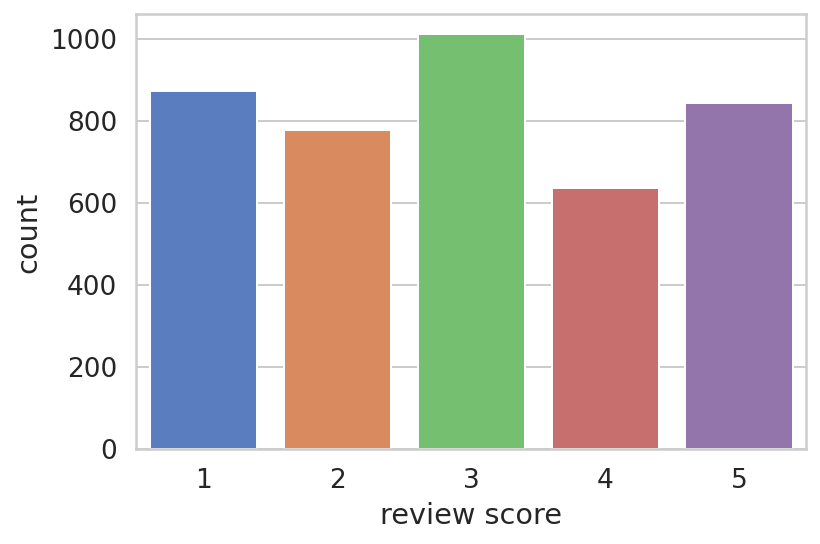

In [18]:
sns.countplot(df.score)
plt.xlabel('review score');

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


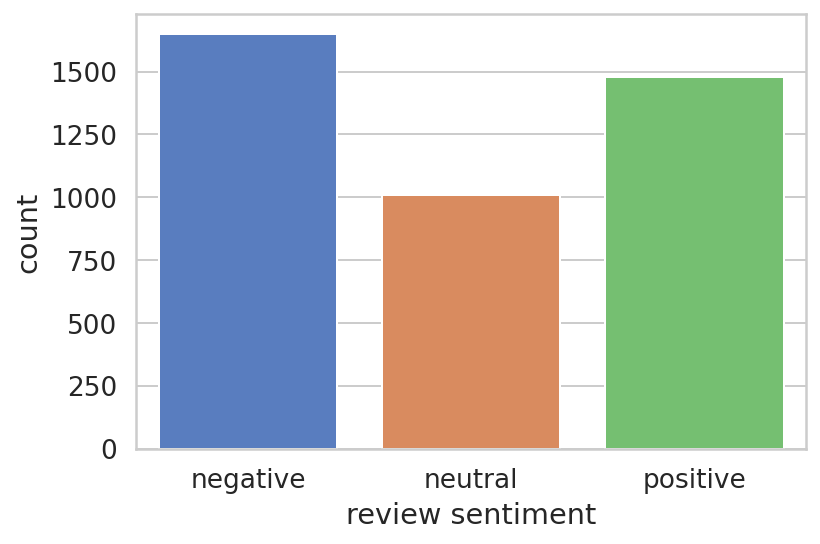

In [19]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else: 
    return 2

df['sentiment'] = df.score.apply(to_sentiment)
class_names = ['negative', 'neutral', 'positive']
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);


# Data Preprocessing

In [20]:
!pip install -q -U watermark

In [21]:
!pip install -qq transformers

     |████████████████████████████████| 1.3MB 2.8MB/s 
     |████████████████████████████████| 890kB 15.6MB/s 
     |████████████████████████████████| 1.1MB 20.8MB/s 
     |████████████████████████████████| 2.9MB 26.5MB/s 


In [22]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

CPython 3.6.9
IPython 5.5.0

numpy 1.18.5
pandas 1.1.2
torch 1.6.0+cu101
transformers 3.4.0


In [23]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [24]:
PRE_TRAINED_MODEL_NAME = 'bert-base-multilingual-cased'

In [25]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [26]:
sample_txt = 'La comida estaba muy rica'
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: La comida estaba muy rica
   Tokens: ['La', 'comida', 'estaba', 'muy', 'rica']
Token IDs: [10159, 56588, 14645, 13436, 61356]


In [27]:
encoding = tokenizer.encode_plus(
  sample_txt,  
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
  truncation='longest_first'
)
encoding.keys()
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


tensor([  101, 10159, 56588, 14645, 13436, 61356,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])

# comienzo de reviews

In [28]:
token_lens = []
for txt in df.content:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


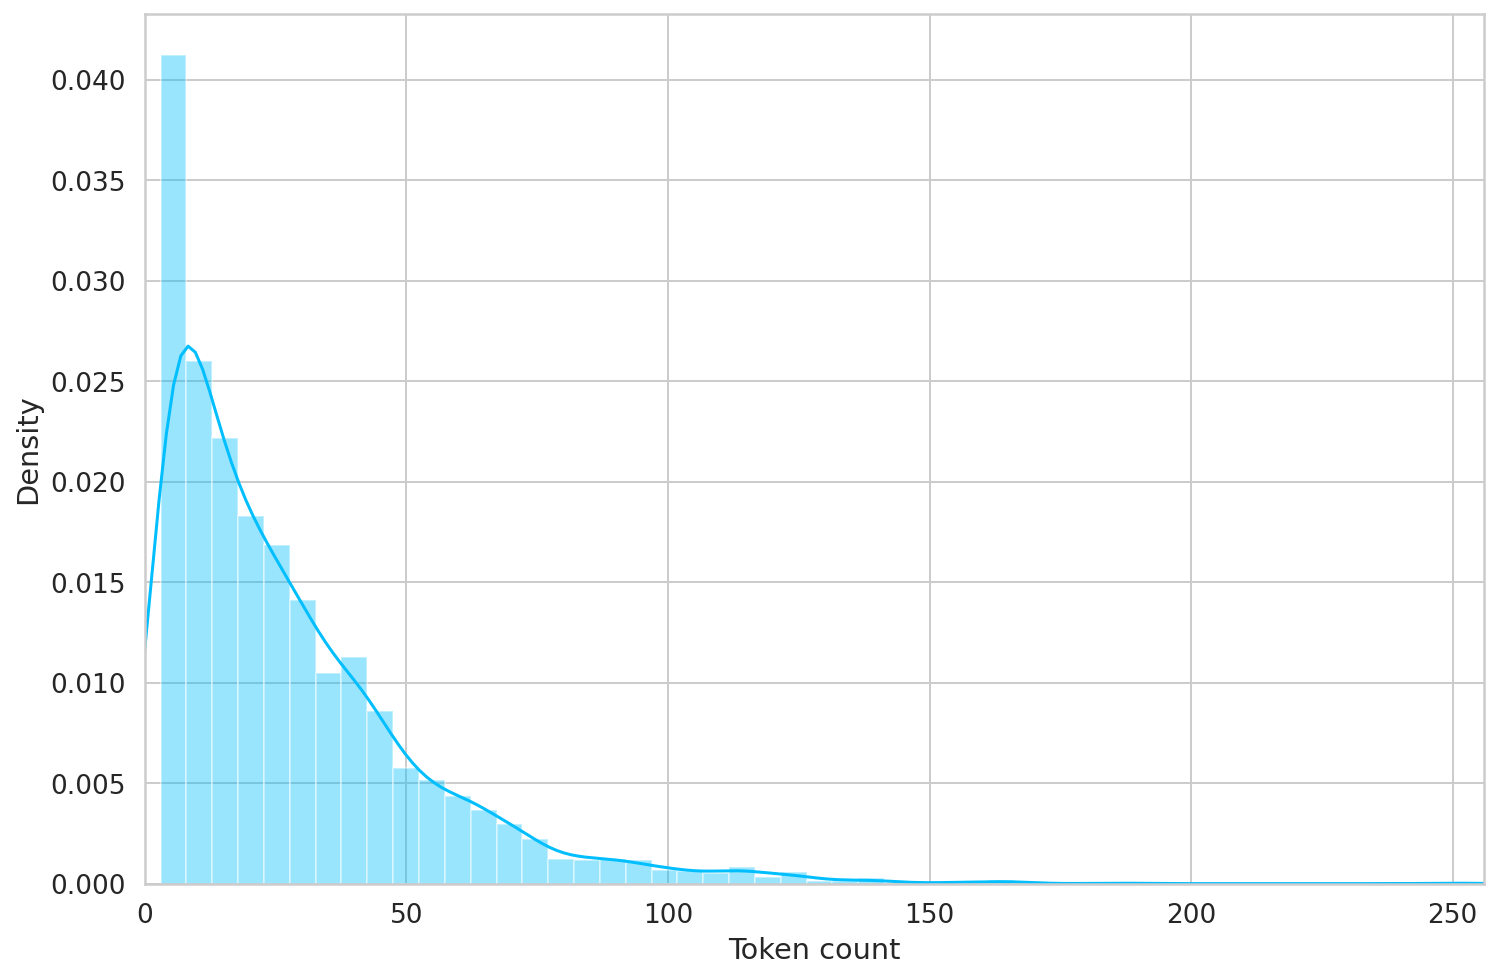

In [29]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [30]:
MAX_LEN = 160
class GPReviewDataset(Dataset):
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.reviews)
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
      truncation='longest_first'
    )
    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [31]:
df_train, df_test = train_test_split(
  df,
  test_size=0.1,
  random_state=RANDOM_SEED
)
df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED
)

In [32]:
df_train.shape, df_val.shape, df_test.shape

((3722, 13), (207, 13), (207, 13))

In [33]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [34]:
BATCH_SIZE = 5
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [35]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [36]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([5, 160])
torch.Size([5, 160])
torch.Size([5])


# BERT Classification

In [37]:
  bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)